In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 11

BASE_DIR = "/Users/guoshuyan/Desktop/OpenAD"
GOLD_DATA_CSV = os.path.join(BASE_DIR, "final_gold.csv")

# Schema - full fields
SCHEMA_FIELDS = [
    "trial_id",
    "criterion_type",
    "ad_domain",
    "clinical_concept",
    "operator",
    "value_lower",
    "value_upper",
    "units",
    "diagnostic_framework",
    "severity_stage",
    "source_sentence",
    "temporal_scope",
    "evidence_type",
    "certainty",
]

ID_FIELDS = ["trial_id", "criterion_type", "source_sentence"]
VALUE_FIELDS = [f for f in SCHEMA_FIELDS if f not in ID_FIELDS]

print("Configuration loaded:")
print(f"  BASE_DIR: {BASE_DIR}")
print(f"  Gold data: {GOLD_DATA_CSV}")
print(f"  Schema fields: {len(SCHEMA_FIELDS)}")
print(f"  Value fields: {len(VALUE_FIELDS)}")


Configuration loaded:
  BASE_DIR: /Users/guoshuyan/Desktop/OpenAD
  Gold data: /Users/guoshuyan/Desktop/OpenAD/final_gold.csv
  Schema fields: 14
  Value fields: 11


In [9]:
def normalize_value(x):
    """Normalize values for comparison (handle NA, empty, case-insensitive)."""
    if pd.isna(x):
        return None
    s = str(x).strip().lower()
    if s in {"", "na", "n/a", "nan", "none", "null"}:
        return None
    return s

def calculate_per_field_accuracy():
    """Calculate comprehensive per-field metrics for 5 models against final_gold.csv"""
    
    # All 5 models to evaluate
    models_to_evaluate = ['GPT_4o', 'Deepseek_R1', 'Gemini_2.5', 'KIMI_K2', 'Qwen3-max']
    model_display_names = ['GPT-4o', 'DeepSeek-R1', 'Gemini-2.5', 'KIMI-K2', 'Qwen3-max']
    
    # Load gold data
    gold_df = pd.read_csv(GOLD_DATA_CSV)
    
    print("Calculating per-field accuracy for:")
    print(f"  Models: {', '.join(model_display_names)}")
    print(f"  Gold standard: {GOLD_DATA_CSV}")
    print()
    
    all_field_results = []
    
    for model_file, model_display in zip(models_to_evaluate, model_display_names):
        extracted_path = f"{BASE_DIR}/{model_file}_extracted.csv"
        
        if not os.path.exists(extracted_path):
            print(f"  Warning: {model_display} extracted file not found: {extracted_path}")
            continue
        
        print(f"  Processing {model_display}...")
        
        try:
            pred_df = pd.read_csv(extracted_path)
            
            # Ensure all schema fields are present
            for field in SCHEMA_FIELDS:
                if field not in pred_df.columns:
                    pred_df[field] = ""
            
            # Merge on ID fields
            merged = pred_df.merge(
                gold_df[SCHEMA_FIELDS],
                on=ID_FIELDS,
                how="inner",
                suffixes=("_pred", "_gold"),
            )
            
            if len(merged) == 0:
                print(f"    Warning: No matching rows found for {model_display}")
                continue
            
            # Calculate per-field metrics (Accuracy, Precision, Recall, F1)
            for field in VALUE_FIELDS:
                pc = f"{field}_pred"
                gc = f"{field}_gold"
                
                pred_vals = merged[pc].apply(normalize_value)
                gold_vals = merged[gc].apply(normalize_value)
                
                # Only compare cells where gold has non-NA content
                mask_valid = gold_vals.notna()
                
                if mask_valid.sum() > 0:
                    # Accuracy: correct predictions / total valid
                    field_correct = ((pred_vals == gold_vals) & mask_valid).sum()
                    field_acc = field_correct / mask_valid.sum()
                    total_valid = mask_valid.sum()
                    
                    # Additional metrics
                    # True Positives: predicted non-NA and matches gold
                    tp = ((pred_vals == gold_vals) & mask_valid & pred_vals.notna()).sum()
                    # False Positives: predicted non-NA but doesn't match gold
                    fp = ((pred_vals != gold_vals) & mask_valid & pred_vals.notna()).sum()
                    # False Negatives: gold has value but predicted is NA or wrong
                    fn = ((pred_vals != gold_vals) & mask_valid).sum()
                    
                    # Precision: of all predicted values, how many are correct
                    precision = tp / (tp + fp) if (tp + fp) > 0 else np.nan
                    # Recall: of all gold values, how many were correctly predicted
                    recall = tp / (tp + fn) if (tp + fn) > 0 else np.nan
                    # F1 Score: harmonic mean of precision and recall
                    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else np.nan
                else:
                    field_acc = np.nan
                    total_valid = 0
                    precision = np.nan
                    recall = np.nan
                    f1 = np.nan
                
                all_field_results.append({
                    "model": model_display,
                    "field": field,
                    "accuracy": field_acc,
                    "precision": precision,
                    "recall": recall,
                    "f1_score": f1,
                    "n_valid": total_valid,
                })
            
            print(f"    Completed {model_display}: {len(merged)} matched rows")
            
        except Exception as e:
            print(f"    Error processing {model_display}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # Create DataFrame
    field_results_df = pd.DataFrame(all_field_results)
    
    if len(field_results_df) == 0:
        print("\nNo results to display.")
        return None, None
    
    # Create pivot table for heatmap
    heat_df = field_results_df.pivot(
        index="field",
        columns="model",
        values="accuracy"
    )
    
    # Reorder to match VALUE_FIELDS order
    heat_df = heat_df.reindex(VALUE_FIELDS)
    
    # Calculate mean accuracy per field (across all models) and drop lowest 5
    field_means = heat_df.mean(axis=1).sort_values()
    fields_to_drop = field_means.head(5).index.tolist()
    heat_df_filtered = heat_df.drop(fields_to_drop)
    
    print("\n" + "="*80)
    print("Dropped Fields (Lowest 5 by Mean Accuracy):")
    print("="*80)
    for field in fields_to_drop:
        mean_acc = field_means[field]
        print(f"  {field}: {mean_acc:.4f}")
    print()
    
    # Print summary table (full)
    print("\n" + "="*80)
    print("Per-Field Accuracy Summary (All Fields)")
    print("="*80)
    print(heat_df.round(4).to_string())
    print()
    
    # Print filtered summary table
    print("\n" + "="*80)
    print("Per-Field Accuracy Summary (Top Fields - Excluding Lowest 5)")
    print("="*80)
    print(heat_df_filtered.round(4).to_string())
    print()
    
    # Create enhanced heatmap with better styling
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Comprehensive Per-Field Evaluation: 5 Models\n(Excluding Lowest 5 Fields)', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    # 1. Accuracy Heatmap
    ax1 = axes[0, 0]
    sns.heatmap(
        heat_df_filtered * 100,
        annot=True,
        fmt=".1f",
        cmap="RdYlGn",
        vmin=0,
        vmax=100,
        linewidths=1.5,
        linecolor='white',
        square=True,
        ax=ax1,
        cbar_kws={"shrink": 0.8, "label": "Accuracy (%)"}
    )
    ax1.set_title("Accuracy", fontsize=14, fontweight='bold', pad=10)
    ax1.set_xlabel("Model", fontsize=12, fontweight='bold')
    ax1.set_ylabel("Field", fontsize=12, fontweight='bold')
    ax1.tick_params(axis='both', labelsize=10)
    
    # 2. Precision Heatmap
    precision_df = field_results_df.pivot(index="field", columns="model", values="precision").reindex(VALUE_FIELDS).drop(fields_to_drop)
    ax2 = axes[0, 1]
    sns.heatmap(
        precision_df * 100,
        annot=True,
        fmt=".1f",
        cmap="YlOrBr",
        vmin=0,
        vmax=100,
        linewidths=1.5,
        linecolor='white',
        square=True,
        ax=ax2,
        cbar_kws={"shrink": 0.8, "label": "Precision (%)"}
    )
    ax2.set_title("Precision", fontsize=14, fontweight='bold', pad=10)
    ax2.set_xlabel("Model", fontsize=12, fontweight='bold')
    ax2.set_ylabel("")
    ax2.tick_params(axis='both', labelsize=10)
    
    # 3. Recall Heatmap
    recall_df = field_results_df.pivot(index="field", columns="model", values="recall").reindex(VALUE_FIELDS).drop(fields_to_drop)
    ax3 = axes[1, 0]
    sns.heatmap(
        recall_df * 100,
        annot=True,
        fmt=".1f",
        cmap="Blues",
        vmin=0,
        vmax=100,
        linewidths=1.5,
        linecolor='white',
        square=True,
        ax=ax3,
        cbar_kws={"shrink": 0.8, "label": "Recall (%)"}
    )
    ax3.set_title("Recall", fontsize=14, fontweight='bold', pad=10)
    ax3.set_xlabel("Model", fontsize=12, fontweight='bold')
    ax3.set_ylabel("Field", fontsize=12, fontweight='bold')
    ax3.tick_params(axis='both', labelsize=10)
    
    # 4. F1 Score Heatmap
    f1_df = field_results_df.pivot(index="field", columns="model", values="f1_score").reindex(VALUE_FIELDS).drop(fields_to_drop)
    ax4 = axes[1, 1]
    sns.heatmap(
        f1_df * 100,
        annot=True,
        fmt=".1f",
        cmap="Purples",
        vmin=0,
        vmax=100,
        linewidths=1.5,
        linecolor='white',
        square=True,
        ax=ax4,
        cbar_kws={"shrink": 0.8, "label": "F1 Score (%)"}
    )
    ax4.set_title("F1 Score", fontsize=14, fontweight='bold', pad=10)
    ax4.set_xlabel("Model", fontsize=12, fontweight='bold')
    ax4.set_ylabel("")
    ax4.tick_params(axis='both', labelsize=10)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    
    # Save plot
    plot_path = f"{BASE_DIR}/per_field_accuracy_heatmap_enhanced.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Enhanced heatmap saved to: {plot_path}")
    plt.show()
    
    # Also create a single comprehensive accuracy heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        heat_df_filtered * 100,
        annot=True,
        fmt=".1f",
        cmap="RdYlGn",
        cbar_kws={"label": "Accuracy (%)", "shrink": 0.8},
        vmin=0,
        vmax=100,
        linewidths=2,
        linecolor='white',
        square=True,
        annot_kws={"size": 11, "weight": "bold"}
    )
    plt.title(f"Per-Field Accuracy: {', '.join(model_display_names)}\n(Excluding Lowest 5 Fields)", 
              fontsize=18, fontweight='bold', pad=20)
    plt.xlabel("Model", fontsize=14, fontweight='bold')
    plt.ylabel("Field", fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    plt.tight_layout()
    
    plot_path_single = f"{BASE_DIR}/per_field_accuracy_heatmap.png"
    plt.savefig(plot_path_single, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Single heatmap saved to: {plot_path_single}")
    plt.show()
    
    # Save detailed results
    results_path = f"{BASE_DIR}/per_field_accuracy_detailed.csv"
    field_results_df.to_csv(results_path, index=False)
    print(f"Detailed results saved to: {results_path}")
    
    # Enhanced per-model summary with all metrics
    print("\n" + "="*80)
    print("Overall Performance by Model (All Metrics)")
    print("="*80)
    model_summary = field_results_df.groupby("model").agg({
        "accuracy": ["mean", "std"],
        "precision": "mean",
        "recall": "mean",
        "f1_score": "mean",
        "n_valid": "sum"
    }).round(4)
    model_summary.columns = ["Mean Accuracy", "Std Accuracy", "Mean Precision", "Mean Recall", "Mean F1", "Total Valid Cells"]
    print(model_summary.to_string())
    print()
    
    # Per-field summary statistics
    print("\n" + "="*80)
    print("Per-Field Statistics (Across All Models)")
    print("="*80)
    field_stats = field_results_df.groupby("field").agg({
        "accuracy": ["mean", "std", "min", "max"],
        "precision": "mean",
        "recall": "mean",
        "f1_score": "mean"
    }).round(4)
    field_stats.columns = ["Acc Mean", "Acc Std", "Acc Min", "Acc Max", "Prec Mean", "Rec Mean", "F1 Mean"]
    print(field_stats.to_string())
    print()
    
    # Best performing model per field
    print("\n" + "="*80)
    print("Best Model per Field (by Accuracy)")
    print("="*80)
    best_models = field_results_df.loc[field_results_df.groupby("field")["accuracy"].idxmax()][["field", "model", "accuracy", "f1_score"]]
    best_models = best_models.sort_values("accuracy", ascending=False)
    best_models.columns = ["Field", "Best Model", "Accuracy", "F1 Score"]
    print(best_models.to_string(index=False))
    print()
    
    # Overall Performance by Model (Top 5 Fields Only)
    print("\n" + "="*80)
    print("Overall Performance by Model (Top 5 Fields Only)")
    print("="*80)
    
    # Identify top 5 fields by mean accuracy
    field_means = field_results_df.groupby("field")["accuracy"].mean().sort_values(ascending=False)
    top_5_fields = field_means.head(5).index.tolist()
    
    print(f"Top 5 Fields: {', '.join(top_5_fields)}")
    print()
    
    # Filter to top 5 fields only
    top_5_df = field_results_df[field_results_df["field"].isin(top_5_fields)]
    
    # Calculate overall performance metrics for each model (top 5 fields only)
    top_5_model_summary = top_5_df.groupby("model").agg({
        "accuracy": ["mean", "std"],
        "precision": "mean",
        "recall": "mean",
        "f1_score": "mean",
        "n_valid": "sum"
    }).round(4)
    top_5_model_summary.columns = ["Mean Accuracy", "Std Accuracy", "Mean Precision", "Mean Recall", "Mean F1", "Total Valid Cells"]
    
    # Sort by mean accuracy (descending)
    top_5_model_summary = top_5_model_summary.sort_values("Mean Accuracy", ascending=False)
    
    print(top_5_model_summary.to_string())
    print()
    
    # Calculate overall average across all models for top 5 fields
    overall_avg_accuracy = top_5_df["accuracy"].mean()
    overall_avg_precision = top_5_df["precision"].mean()
    overall_avg_recall = top_5_df["recall"].mean()
    overall_avg_f1 = top_5_df["f1_score"].mean()
    
    print(f"Overall Average (Top 5 Fields, All Models):")
    print(f"  Accuracy:  {overall_avg_accuracy:.4f} ({overall_avg_accuracy*100:.2f}%)")
    print(f"  Precision: {overall_avg_precision:.4f} ({overall_avg_precision*100:.2f}%)")
    print(f"  Recall:    {overall_avg_recall:.4f} ({overall_avg_recall*100:.2f}%)")
    print(f"  F1 Score:  {overall_avg_f1:.4f} ({overall_avg_f1*100:.2f}%)")
    print()
    
    return field_results_df, heat_df_filtered

print("Functions defined. Run calculate_per_field_accuracy() to execute.")

Functions defined. Run calculate_per_field_accuracy() to execute.


Calculating per-field accuracy for:
  Models: GPT-4o, DeepSeek-R1, Gemini-2.5, KIMI-K2, Qwen3-max
  Gold standard: /Users/guoshuyan/Desktop/OpenAD/final_gold.csv

  Processing GPT-4o...
    Completed GPT-4o: 699 matched rows
  Processing DeepSeek-R1...
    Completed DeepSeek-R1: 732 matched rows
  Processing Gemini-2.5...
    Completed Gemini-2.5: 962 matched rows
  Processing KIMI-K2...
    Completed KIMI-K2: 788 matched rows
  Processing Qwen3-max...
    Completed Qwen3-max: 486 matched rows

Dropped Fields (Lowest 5 by Mean Accuracy):
  clinical_concept: 0.0815
  severity_stage: 0.1838
  operator: 0.1854
  value_upper: 0.2591
  value_lower: 0.3713


Per-Field Accuracy Summary (All Fields)
model                 DeepSeek-R1  GPT-4o  Gemini-2.5  KIMI-K2  Qwen3-max
field                                                                    
ad_domain                  0.4358  0.4092      0.4241   0.4048     0.4074
clinical_concept           0.0699  0.0821      0.0542   0.0906     0.1108
ope

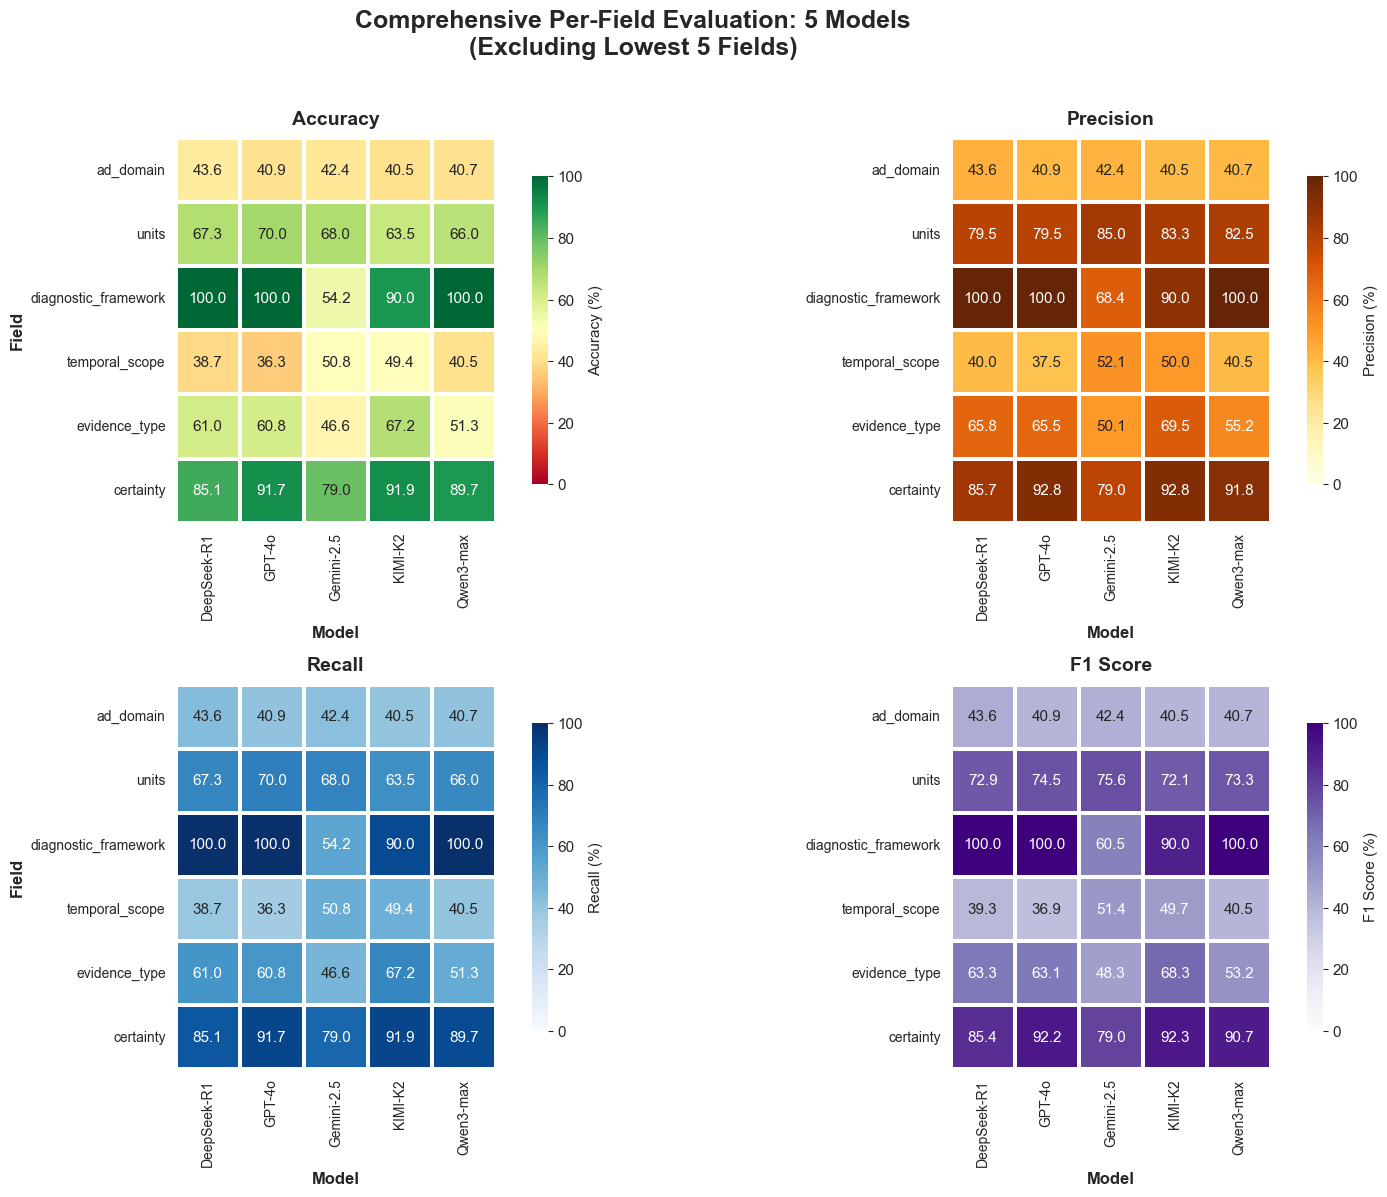

Single heatmap saved to: /Users/guoshuyan/Desktop/OpenAD/per_field_accuracy_heatmap.png


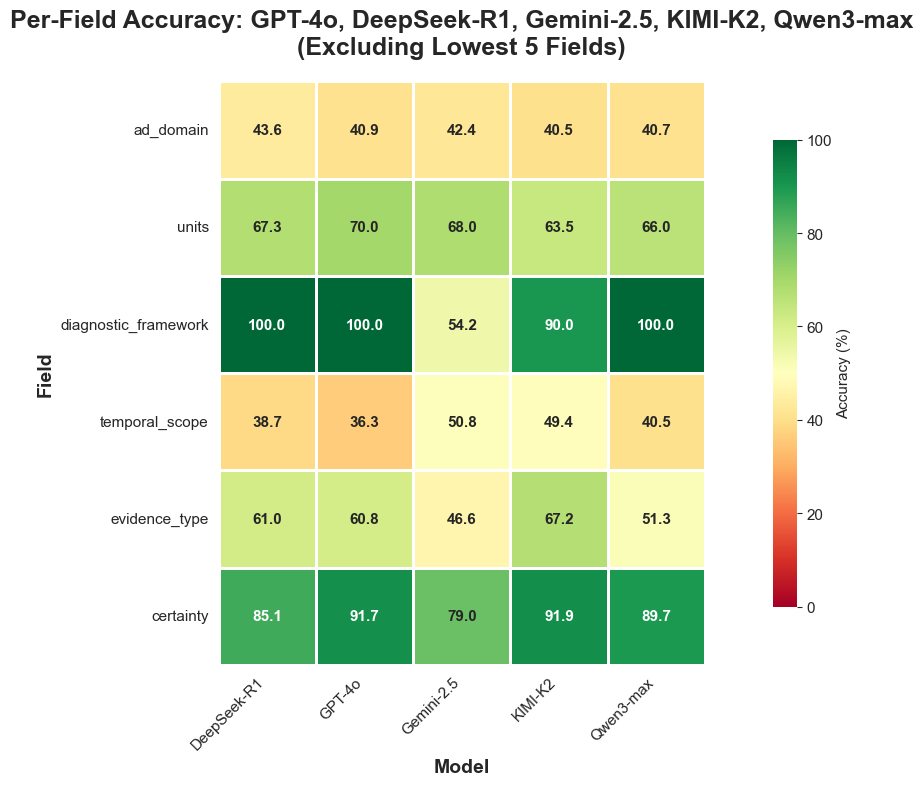

Detailed results saved to: /Users/guoshuyan/Desktop/OpenAD/per_field_accuracy_detailed.csv

Overall Performance by Model (All Metrics)
             Mean Accuracy  Std Accuracy  Mean Precision  Mean Recall  Mean F1  Total Valid Cells
model                                                                                            
DeepSeek-R1         0.4220        0.3245          0.4453       0.4220   0.4328               3067
GPT-4o              0.4900        0.3109          0.5376       0.4900   0.5104               2948
Gemini-2.5          0.3651        0.2560          0.4251       0.3651   0.3885               4103
KIMI-K2             0.4593        0.3315          0.5118       0.4593   0.4790               3412
Qwen3-max           0.5069        0.2898          0.5643       0.5069   0.5319               2124


Per-Field Statistics (Across All Models)
                      Acc Mean  Acc Std  Acc Min  Acc Max  Prec Mean  Rec Mean  F1 Mean
field                                           

In [8]:
# Run per-field accuracy calculation
field_results_df, heat_df = calculate_per_field_accuracy()
